In [3]:
%load_ext autoreload

In [4]:
cd ..

/home/mars/Documents/src_aiai


In [5]:
%autoreload 2
%aimport src.visualisation

In [6]:
import numpy as np
import glob
from skimage import io, color
from tqdm import tqdm

In [7]:
from src.data import load_M51
from src.sampling.uv_sampling import spider_sampling
from src.operators.measurement import NUFFT_op
from src.solvers import PrimalDual_l1_constrained
from src.visualisation import compare
from src.operators.dictionary import wavelet_basis

In [8]:
def load_BSDS(i=0, size=256):
    files = glob.glob("./data/BSR/BSDS500/data/images/test/*.jpg")
    data = io.imread(files[i])
    center = (data.shape[0]//2-size//2, data.shape[1]//2-size//2)
    data = color.rgb2gray(data[center[0]:center[0]+size,center[1]:center[1]+size])
    return data

In [9]:
uv = spider_sampling()
m_op = NUFFT_op(uv, (128,128), (256,256), (3,3))

class id_op():
    def dir_op(self, x):
        return x
    def adj_op(self, x):
        return x
    def self_adj(self, x):
        return x

# m_op = id_op()

In [10]:
x_true = load_BSDS(5, size=128)

y0 = m_op.dir_op(x_true)
ISNR = 20 #dB
sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
noise = np.random.normal(0, sigma, y0.shape) #+ 1j * np.random.normal(0, sigma, y0.shape)
y_ = y0 + noise

x_dirty = m_op.adj_op(y_)
noise_val = np.std((m_op.adj_op(noise)))

In [11]:
dist = -1 * np.dot(uv, uv.T) -1 * np.dot(uv, uv.T).T + np.sum(uv**2, axis=1) + np.sum(uv**2, axis=1)[:,np.newaxis] # (x-y)'(x-y) = x'x + y'y - x'y -y'x
dist[dist < 0] = 0 # correct for numerical errors
gridsize = 2*np.pi/512
w = 1/np.sum(dist**.5 < gridsize, axis=1) # all pixels within 1 gridcell distancex_f = m_op.adj_op(y_*w/w.max())


In [12]:
x_f = m_op.adj_op(y_*w)

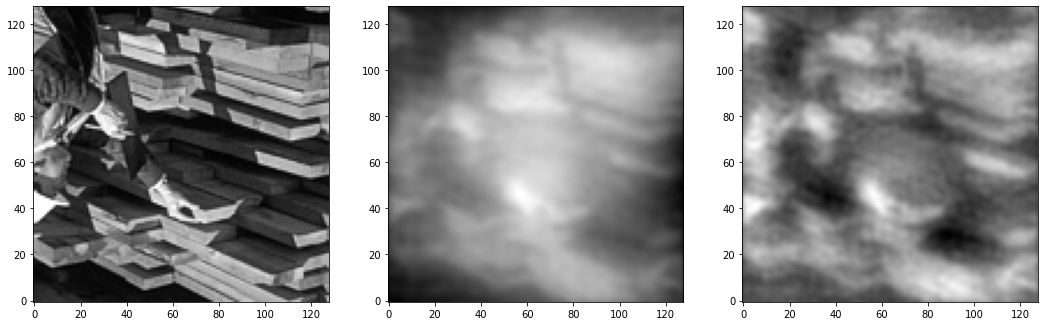

In [13]:
compare([x_true.real, x_dirty.real, x_f.real])

## model

In [20]:
import tensorflow as tf

In [21]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [27]:
def conv_block(x, filters=64, kernel_size=3):
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(padding='same')(x)
    return x

def concatenate_block(x, y):
    return tf.keras.layers.Concatenate()([x,y])

def deconv_block(x, filters=64, kernel_size=3, skip_connection=None):
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D()(x)
    if skip_connection is not None:
        x = concatenate_block(x,skip_connection)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

In [2]:
from src.network import small_unet

In [14]:
model = small_unet()

In [15]:
model.summary()

Model: "unet_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 128, 128, 16) 64          conv2d_15[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 16)   0           batch_normalization_14[0][0]     
_____________________________________________________________________________________________

In [98]:
# loss = tf.keras.losses.MSE(inputs, outputs)
# model.compile(optimizer='Adam', loss=tf.keras.losses.MSE)

## Data

In [16]:
def get_data(num_samples, ISNR=20, size=256):
    x_true, x_dirty = np.zeros((num_samples, size, size, 1)), np.zeros((num_samples, size, size, 1))
    scaling = np.linalg.norm(uv, axis=1)
    scaling /= scaling.max()
    for i in tqdm(range(num_samples)):
        x_true_ = load_BSDS(i, size=size)

        y0 = m_op.dir_op(x_true_)
        sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
        noise = np.random.normal(0, sigma, y0.shape) #+ 1j * np.random.normal(0, sigma, y0.shape)
        y_ = (y0 + noise)

        x_dirty_ = m_op.adj_op(y_*w)
        x_true[i] = x_true_.reshape(size,size,1)
        x_dirty[i] = x_dirty_.reshape(size,size,1)
        
        
    return x_true.real, x_dirty.real
#         noise_val = np.std((m_op.adj_op(noise)))

In [25]:
y,x  = get_data(200, size=128, ISNR=50)

  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-16-1eb1c7039a39>:15: ComplexWarning: Casting complex values to real discards the imaginary part
  x_dirty[i] = x_dirty_.reshape(size,size,1)
100%|██████████| 200/200 [00:03<00:00, 52.26it/s]


In [72]:
y.dtype

dtype('float64')

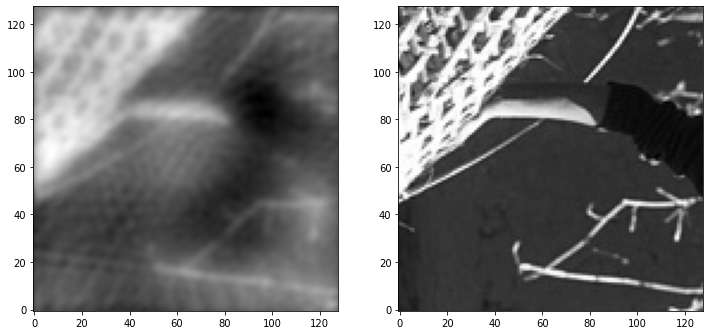

In [18]:
i = 28
compare([x[i].real, y[i].real])

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
## training

In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

NameError: name 'tf' is not defined

In [38]:
x.shape

(200, 128, 128, 1)

In [26]:
%%time
model.fit(x, y, epochs=100, verbose=0)

CPU times: user 28.3 s, sys: 872 ms, total: 29.2 s
Wall time: 36.6 s


In [27]:
y_pred = model.predict(x)

38.76734967105156


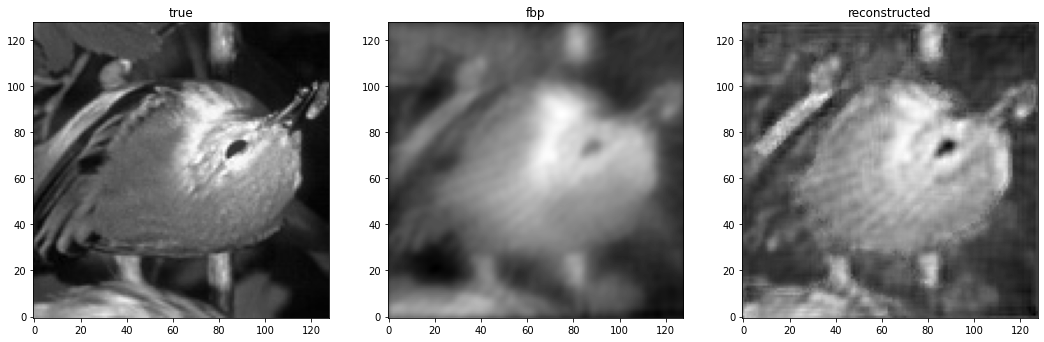

39.140936654605795


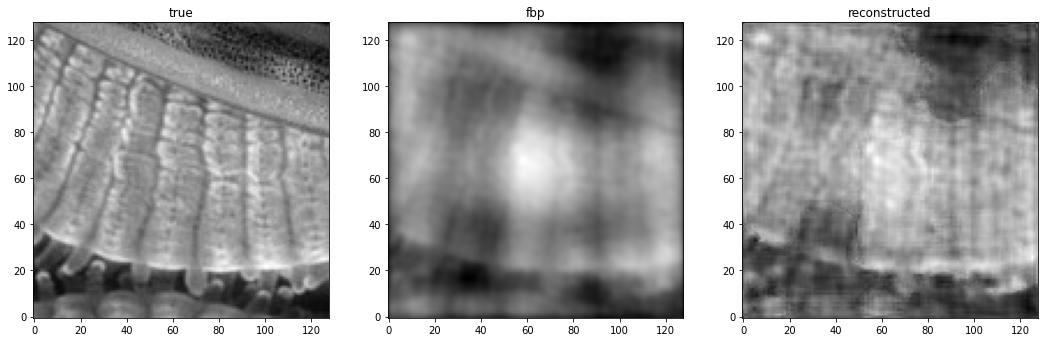

34.20353070928968


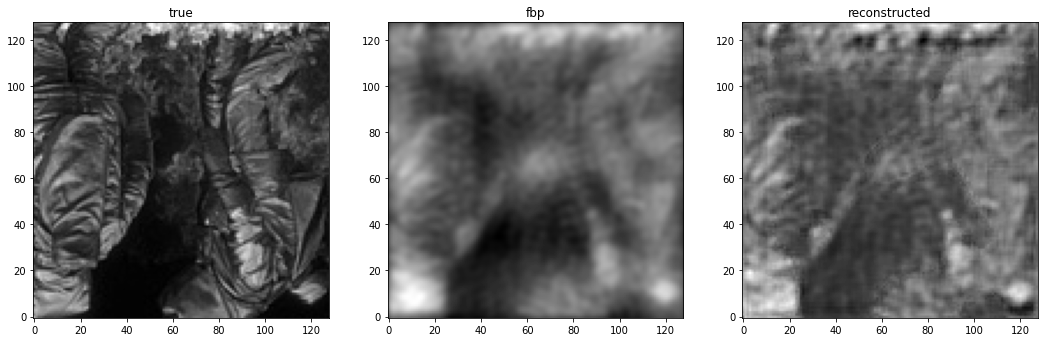

35.99353390938703


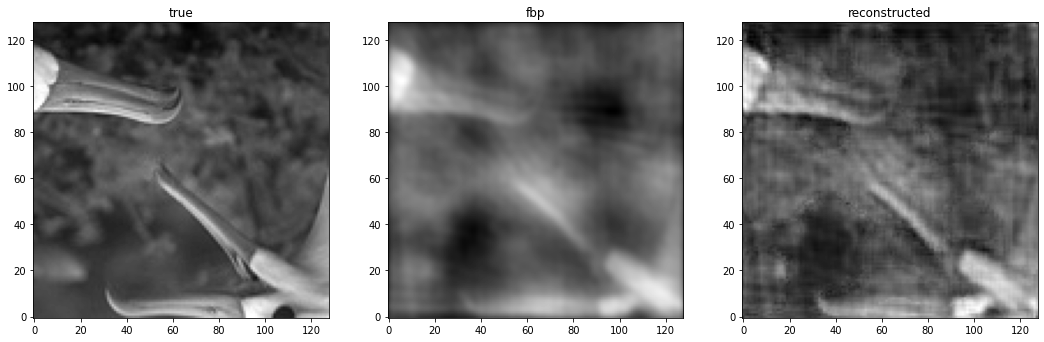

41.22252022012482


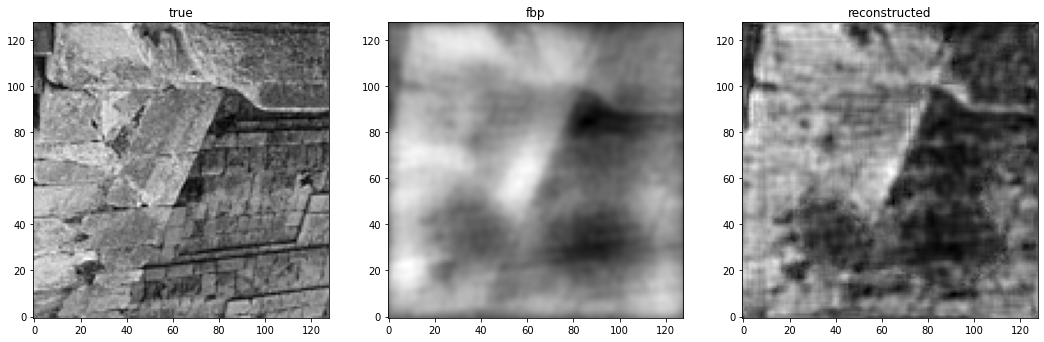

In [28]:
for i in range(5):
    print(np.linalg.norm(x[i]-y_pred[i]))
    compare([y[i].real, x[i].real, y_pred[i].real], same_scale=False, titles=["true", "fbp", "reconstructed"])

In [81]:
def dirty(x_true_, ISNR, m_op):
    size = x_true_.shape[0]
    
    y0 = m_op.dir_op(x_true_)
    sigma = np.sqrt(np.mean(np.abs(y0)**2)) * 10**(-ISNR/20)
    noise = np.random.normal(0, sigma, y0.shape) #+ 1j * np.random.normal(0, sigma, y0.shape)
    y_ = (y0 + noise)

    x_dirty_ = m_op.adj_op(y_*w)

    return x_dirty_.reshape(1,size,size,1).real

In [82]:
d_im.shape

(1, 128, 128, 1)

In [83]:
im = load_M51()[::2, ::2]
d_im = dirty(im, 50, m_op)
im_p = model.predict(d_im)

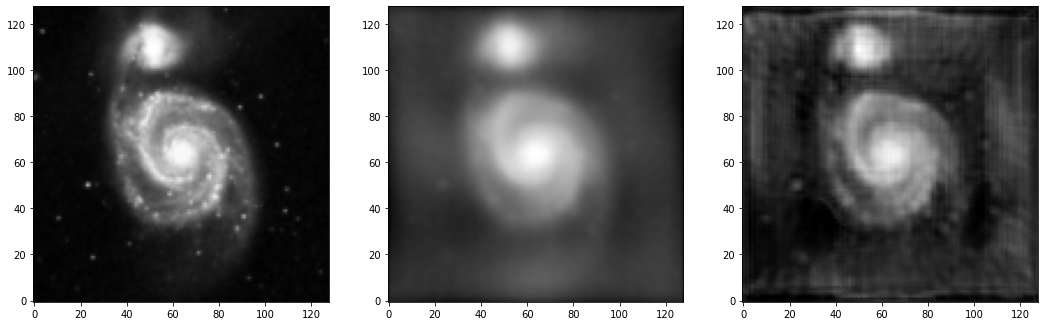

In [84]:
compare([im, d_im[0], im_p[0]])

In [33]:
a = np.load("./data/intermediate/x_true_train_50dB.npy")
b = np.load("./data/intermediate/x_dirty_train_50dB.npy")
c = np.load("./data/intermediate/noise_levels_train_50dB.npy")

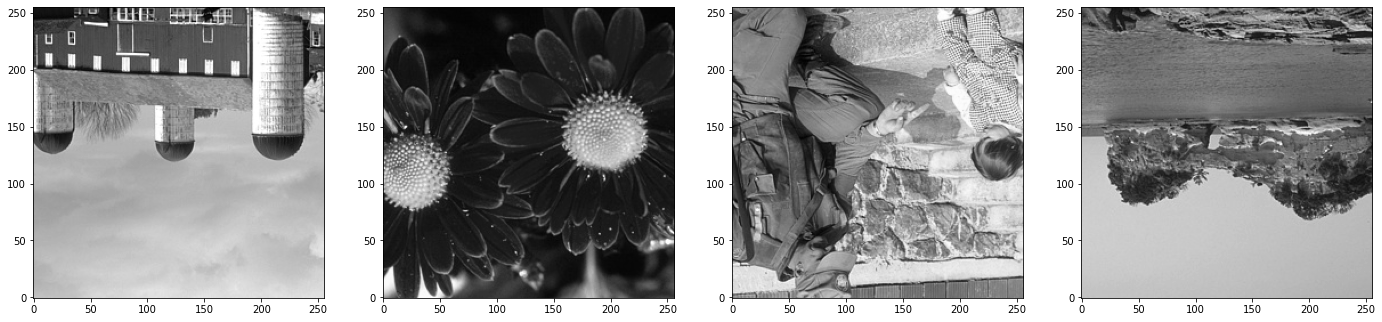

In [34]:
compare(a[:4,:,:,0])

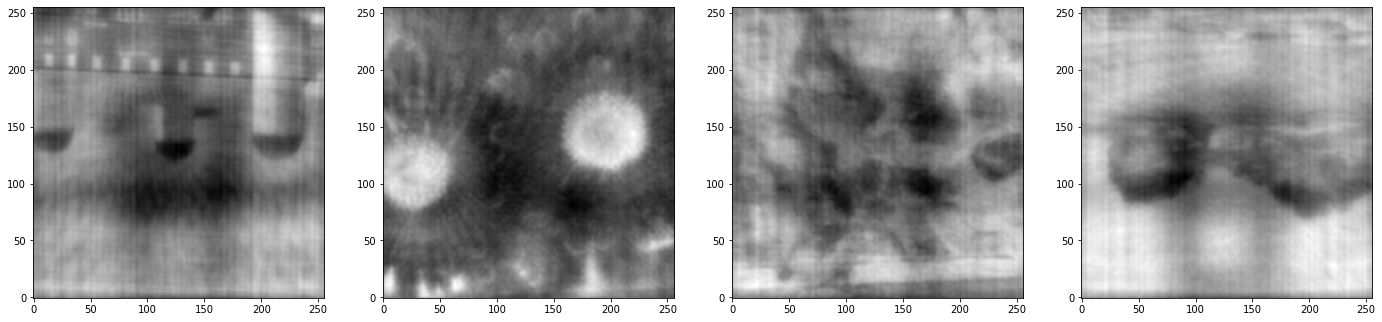

In [35]:
compare(b[:4,:,:,0])

In [39]:
np.mean(c)/ np.std(c)

4.1470564000070755